In [1]:
import pandas as pd
diab = pd.read_csv("diabetes.csv")
# Variables are
# subject: subject ID number
# age: age diagnosed with diabetes
# acidity: a measure of acidity called base deficit
# y: natural log of serum C-peptide concentration
# Original source is Sockett et al. (1987)
# mentioned in Hastie and Tibshirani's book 
# "Generalized Additive Models".

In [2]:
import numpy as np
xpred = np.arange(0,16.1,0.1).reshape(-1,1)

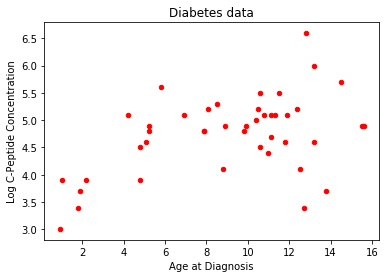

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
ax0 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data")
_ = ax0.set_xlabel("Age at Diagnosis")
_ = ax0.set_ylabel("Log C-Peptide Concentration")

In [4]:
#Using scikit-learn
from sklearn.linear_model import LinearRegression
fit1_lm = LinearRegression()
fit1_lm.fit(diab[['age']],diab[['y']])
pred1_sklearn = fit1_lm.predict(xpred)
# unforunately, scikit-learn lacks built-in methods for computing prediction standard errors!

In [5]:
#Using statsmodels
#also, patsy (part of the backend to statsemodels) recognizes numpy functions
import statsmodels.formula.api as sm
diab_dict = {'age':np.array(diab.age),'y':np.array(diab.y)}
model1 = sm.ols('y~age',data=diab_dict)
fit1_lm = model1.fit()
pred1 = np.array(fit1_lm.predict(dict(age=xpred)))
pred1_se = np.array(fit1_lm.get_prediction(dict(age=xpred)).summary_frame().mean_se)

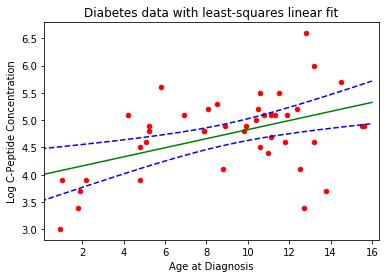

In [6]:
import matplotlib.lines as mlines
ax1 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares linear fit")
_ = ax1.set_xlabel("Age at Diagnosis")
_ = ax1.set_ylabel("Log C-Peptide Concentration")
_ = ax1.add_line(mlines.Line2D(xpred,pred1,color="green"))
_ = ax1.add_line(mlines.Line2D(xpred,pred1 + 1.96 * pred1_se,color="blue",linestyle="dashed"))
_ = ax1.add_line(mlines.Line2D(xpred,pred1 - 1.96 * pred1_se,color="blue",linestyle="dashed"))

In [7]:
from sklearn.preprocessing import PolynomialFeatures
age_poly3 = PolynomialFeatures(3).fit_transform(diab_dict['age'].reshape(-1,1))
model2 = sm.GLS(diab_dict['y'],age_poly3)
fit2_lm = model2.fit()
#need to use the PolynomialFeatures function on the values to be predicted
xpred_poly3 = PolynomialFeatures(3).fit_transform(xpred)
pred2 = np.array(fit2_lm.predict(xpred_poly3))
pred2_se = np.array(fit2_lm.get_prediction(xpred_poly3).summary_frame().mean_se)

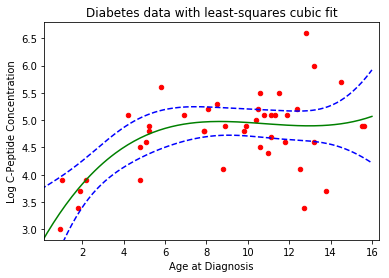

In [8]:
ax2 = diab.plot.scatter(x='age',y='y',c='Red',title="Diabetes data with least-squares cubic fit")
_ = ax2.set_xlabel("Age at Diagnosis")
_ = ax2.set_ylabel("Log C-Peptide Concentration")
_ = ax2.add_line(mlines.Line2D(xpred,pred2,color="green"))
_ = ax2.add_line(mlines.Line2D(xpred,pred2 + 1.96 * pred2_se,color="blue",linestyle="dashed"))
_ = ax2.add_line(mlines.Line2D(xpred,pred2 - 1.96 * pred2_se,color="blue",linestyle="dashed"))

In [9]:
from statsmodels import genmod as gm
#monkey patching the get_prediction function in statsmodels
# to correctly return standard errors (equivalent to R behavior)
# (there is a bug in the statsmodels implementation of the get_prediction function for GLMs)
#what is monkey patching? see https://stackoverflow.com/questions/5626193/what-is-monkey-patching
# and https://en.wikipedia.org/wiki/Monkey_patch
#apparently, this is a known bug in statsmodels: https://github.com/statsmodels/statsmodels/issues/4013
from statsmodels.genmod import _prediction as pred
#modified function from https://github.com/statsmodels/statsmodels/blob/master/statsmodels/genmod/generalized_linear_model.py
def gp_new(self, exog=None, exposure=None, offset=None, transform=True, linear=False, row_labels=None):
    import statsmodels.regression._prediction as linpred
    pred_kwds = {'exposure': exposure, 'offset': offset, 'linear': True}
    
    # two calls to a get_prediction duplicates exog generation if patsy
    res_linpred = linpred.get_prediction(self, exog=exog, transform=transform, row_labels=row_labels, pred_kwds=pred_kwds)
    
    pred_kwds['linear'] = False
    res = pred.get_prediction_glm(self, exog=exog, transform=transform, row_labels=row_labels, linpred=res_linpred, link=self.model.family.link, pred_kwds=pred_kwds)
    if linear:
        return res_linpred
    else:
        return res
gm.generalized_linear_model.GLMResults.get_prediction = gp_new

In [10]:
y_bin = (diab.y > 4).map({False:0, True:1}).values
diab['y_bin'] = y_bin
from statsmodels.tools.tools import add_constant
age_with_const = add_constant(diab_dict['age'])
model1_glm = sm.GLM(y_bin,age_with_const, family=gm.families.Binomial(gm.families.links.logit))
fit1_glm = model1_glm.fit()
pred1_glm = np.array(fit1_glm.predict(add_constant(xpred),linear=True))
pred1_glm_se = np.array(fit1_glm.get_prediction(add_constant(xpred),linear=True).summary_frame().mean_se)

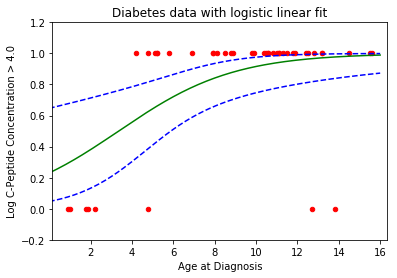

In [11]:
from scipy.stats import logistic
ax3 = diab.plot.scatter(x='age',y='y_bin',c='Red',title="Diabetes data with logistic linear fit")
_ = ax3.set_ylim([-0.2,1.2])
_ = ax3.set_xlabel("Age at Diagnosis")
_ = ax3.set_ylabel("Log C-Peptide Concentration > 4.0")
_ = ax3.add_line(mlines.Line2D(xpred,logistic.cdf(pred1_glm),color="green"))
_ = ax3.add_line(mlines.Line2D(xpred,logistic.cdf(pred1_glm + 1.96 * pred1_glm_se),color="blue",linestyle="dashed"))
_ = ax3.add_line(mlines.Line2D(xpred,logistic.cdf(pred1_glm - 1.96 * pred1_glm_se),color="blue",linestyle="dashed"))

In [12]:
#the PolynomialFeatures function includes an intercept term (include_bias = True) by default
#so no need to use the add_constant function
model2_glm = sm.GLM(y_bin,age_poly3, family=gm.families.Binomial(gm.families.links.logit))
fit2_glm = model2_glm.fit()
pred2_glm = np.array(fit2_glm.predict(xpred_poly3,linear=True))
pred2_glm_se = np.array(fit2_glm.get_prediction(xpred_poly3,linear=True).summary_frame().mean_se)

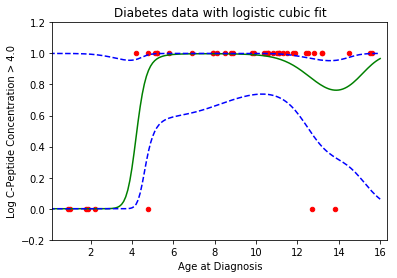

In [13]:
ax4 = diab.plot.scatter(x='age',y='y_bin',c='Red',title="Diabetes data with logistic cubic fit")
_ = ax4.set_ylim([-0.2,1.2])
_ = ax4.set_xlabel("Age at Diagnosis")
_ = ax4.set_ylabel("Log C-Peptide Concentration > 4.0")
_ = ax4.add_line(mlines.Line2D(xpred,logistic.cdf(pred2_glm),color="green"))
_ = ax4.add_line(mlines.Line2D(xpred,logistic.cdf(pred2_glm + 1.96 * pred2_glm_se),color="blue",linestyle="dashed"))
_ = ax4.add_line(mlines.Line2D(xpred,logistic.cdf(pred2_glm - 1.96 * pred2_glm_se),color="blue",linestyle="dashed"))

In [14]:
#From R help on Local Polynomial Regression Fitting:
#The size of the neighbourhood is controlled by α (set by span or enp.target). 
#For α < 1, the neighbourhood includes proportion α of the points, and these have tricubic weighting 
# (proportional to (1 - (dist/maxdist)^3)^3). For α > 1, all points are used, with the 
# ‘maximum distance’ assumed to be α^(1/p) times the actual maximum distance for p explanatory variables.
#However, statsmodels lacks the functionality to properly fit span > 1.

from statsmodels.nonparametric.smoothers_lowess import lowess as lowess
ss1 = lowess(diab_dict['y'],diab_dict['age'],frac=0.15)
ss2 = lowess(diab_dict['y'],diab_dict['age'],frac=0.25)
ss3 = lowess(diab_dict['y'],diab_dict['age'],frac=0.7)
ss4 = lowess(diab_dict['y'],diab_dict['age'],frac=1)

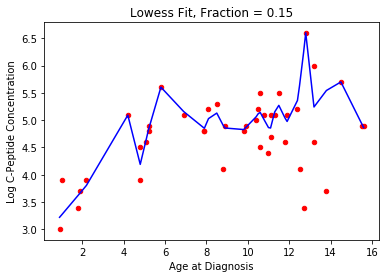

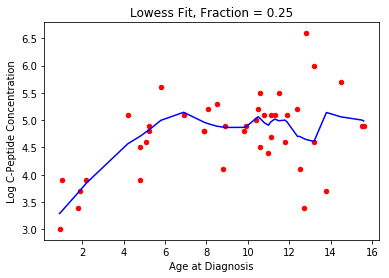

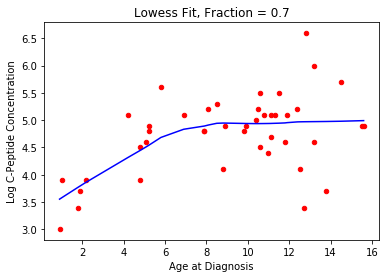

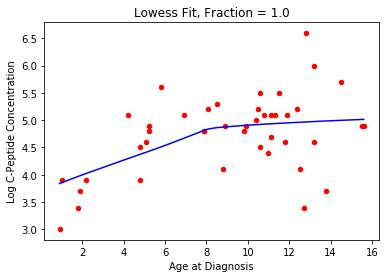

In [15]:
ax5 = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = 0.15")
_ = ax5.set_xlabel("Age at Diagnosis")
_ = ax5.set_ylabel("Log C-Peptide Concentration")
_ = ax5.add_line(mlines.Line2D(ss1[:,0],ss1[:,1],color="blue"))

ax6 = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = 0.25")
_ = ax6.set_xlabel("Age at Diagnosis")
_ = ax6.set_ylabel("Log C-Peptide Concentration")
_ = ax6.add_line(mlines.Line2D(ss2[:,0],ss2[:,1],color="blue"))

ax7 = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = 0.7")
_ = ax7.set_xlabel("Age at Diagnosis")
_ = ax7.set_ylabel("Log C-Peptide Concentration")
_ = ax7.add_line(mlines.Line2D(ss3[:,0],ss3[:,1],color="blue"))

ax8 = diab.plot.scatter(x='age',y='y',c='Red',title="Lowess Fit, Fraction = 1.0")
_ = ax8.set_xlabel("Age at Diagnosis")
_ = ax8.set_ylabel("Log C-Peptide Concentration")
_ = ax8.add_line(mlines.Line2D(ss4[:,0],ss4[:,1],color="blue"))

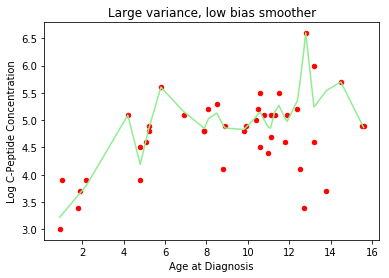

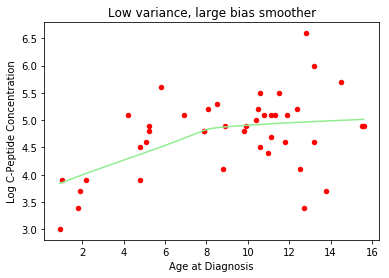

In [16]:
ax9 = diab.plot.scatter(x='age',y='y',c='Red',title="Large variance, low bias smoother")
_ = ax9.set_xlabel("Age at Diagnosis")
_ = ax9.set_ylabel("Log C-Peptide Concentration")
_ = ax9.add_line(mlines.Line2D(ss1[:,0],ss1[:,1],color="lightgreen"))

ax10 = diab.plot.scatter(x='age',y='y',c='Red',title="Low variance, large bias smoother")
_ = ax10.set_xlabel("Age at Diagnosis")
_ = ax10.set_ylabel("Log C-Peptide Concentration")
_ = ax10.add_line(mlines.Line2D(ss4[:,0],ss4[:,1],color="lightgreen"))

In [17]:
import rpy2.robjects as robjects
r_loess = robjects.r['loess.smooth'] #extract R function
r_y = robjects.FloatVector(diab_dict['y'])
r_age = robjects.FloatVector(diab_dict['age'])
ss1_r = r_loess(r_age,r_y,span=0.15)
ss2_r = r_loess(r_age,r_y,span=0.25)
ss3_r = r_loess(r_age,r_y,span=0.7)
ss4_r = r_loess(r_age,r_y,span=4.0)

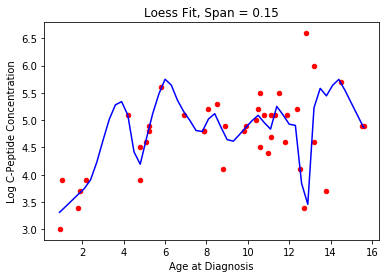

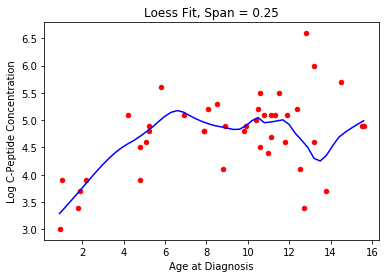

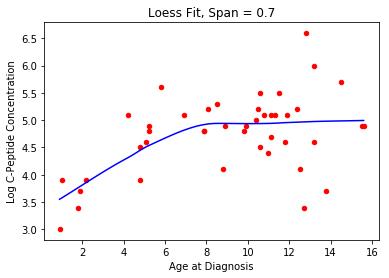

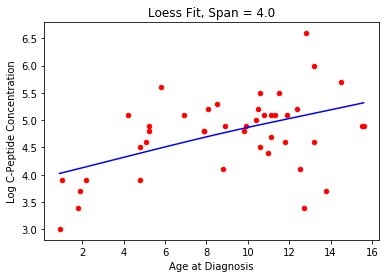

In [18]:
ax11 = diab.plot.scatter(x='age',y='y',c='Red',title="Loess Fit, Span = 0.15")
_ = ax11.set_xlabel("Age at Diagnosis")
_ = ax11.set_ylabel("Log C-Peptide Concentration")
_ = ax11.add_line(mlines.Line2D(np.array(tuple(ss1_r.rx2("x"))),np.array(tuple(ss1_r.rx2("y"))),color="blue"))

ax12 = diab.plot.scatter(x='age',y='y',c='Red',title="Loess Fit, Span = 0.25")
_ = ax12.set_xlabel("Age at Diagnosis")
_ = ax12.set_ylabel("Log C-Peptide Concentration")
_ = ax12.add_line(mlines.Line2D(np.array(tuple(ss2_r.rx2("x"))),np.array(tuple(ss2_r.rx2("y"))),color="blue"))

ax13 = diab.plot.scatter(x='age',y='y',c='Red',title="Loess Fit, Span = 0.7")
_ = ax13.set_xlabel("Age at Diagnosis")
_ = ax13.set_ylabel("Log C-Peptide Concentration")
_ = ax13.add_line(mlines.Line2D(np.array(tuple(ss3_r.rx2("x"))),np.array(tuple(ss3_r.rx2("y"))),color="blue"))

ax14 = diab.plot.scatter(x='age',y='y',c='Red',title="Loess Fit, Span = 4.0")
_ = ax14.set_xlabel("Age at Diagnosis")
_ = ax14.set_ylabel("Log C-Peptide Concentration")
_ = ax14.add_line(mlines.Line2D(np.array(tuple(ss4_r.rx2("x"))),np.array(tuple(ss4_r.rx2("y"))),color="blue"))

In [19]:
r_smooth_spline = robjects.r['smooth.spline'] #extract R function
spline1 = r_smooth_spline(r_age,r_y,spar=0)
spline2 = r_smooth_spline(r_age,r_y,spar=0.5)
spline3 = r_smooth_spline(r_age,r_y,spar=0.9)
spline4 = r_smooth_spline(r_age,r_y,spar=2.0)

#one way to extract lambda: cast to tuple
lambda1 = tuple(spline1.rx2("lambda"))[0]
lambda2 = tuple(spline2.rx2("lambda"))[0]
lambda3 = tuple(spline3.rx2("lambda"))[0]
lambda4 = tuple(spline4.rx2("lambda"))[0]

#another way: cast to string and truncate the R output to make into a Python float
lambda1 = float(str(spline1.rx2("lambda"))[4:-1])
lambda2 = float(str(spline2.rx2("lambda"))[4:-1])
lambda3 = float(str(spline3.rx2("lambda"))[4:-1])
lambda4 = float(str(spline4.rx2("lambda"))[4:-1])


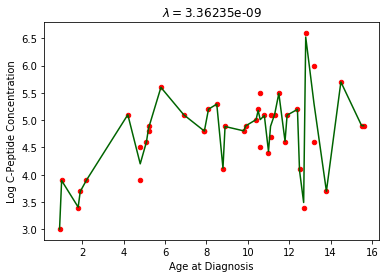

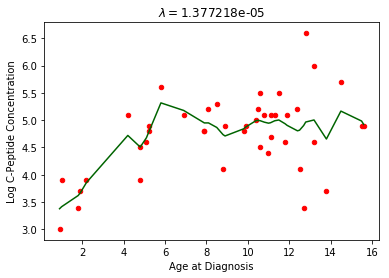

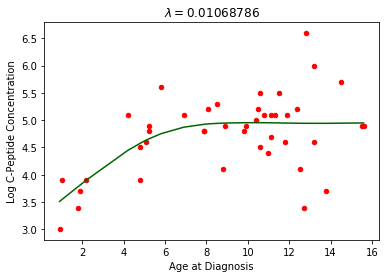

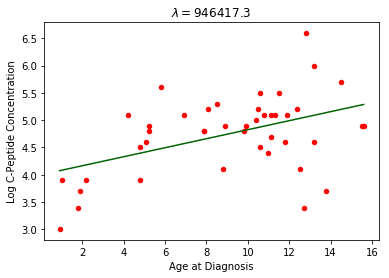

In [20]:
ax15 = diab.plot.scatter(x='age',y='y',c='Red',title="$\lambda=$"+str(lambda1)) #can use TeX style in labels
_ = ax15.set_xlabel("Age at Diagnosis")
_ = ax15.set_ylabel("Log C-Peptide Concentration")
_ = ax15.add_line(mlines.Line2D(np.array(tuple(spline1.rx2("x"))),np.array(tuple(spline1.rx2("y"))),color="darkgreen"))

ax16 = diab.plot.scatter(x='age',y='y',c='Red',title="$\lambda=$"+str(lambda2))
_ = ax16.set_xlabel("Age at Diagnosis")
_ = ax16.set_ylabel("Log C-Peptide Concentration")
_ = ax16.add_line(mlines.Line2D(np.array(tuple(spline2.rx2("x"))),np.array(tuple(spline2.rx2("y"))),color="darkgreen"))

ax17 = diab.plot.scatter(x='age',y='y',c='Red',title="$\lambda=$"+str(lambda3))
_ = ax17.set_xlabel("Age at Diagnosis")
_ = ax17.set_ylabel("Log C-Peptide Concentration")
_ = ax17.add_line(mlines.Line2D(np.array(tuple(spline3.rx2("x"))),np.array(tuple(spline3.rx2("y"))),color="darkgreen"))

ax18 = diab.plot.scatter(x='age',y='y',c='Red',title="$\lambda=$"+str(lambda4))
_ = ax18.set_xlabel("Age at Diagnosis")
_ = ax18.set_ylabel("Log C-Peptide Concentration")
_ = ax18.add_line(mlines.Line2D(np.array(tuple(spline4.rx2("x"))),np.array(tuple(spline4.rx2("y"))),color="darkgreen"))

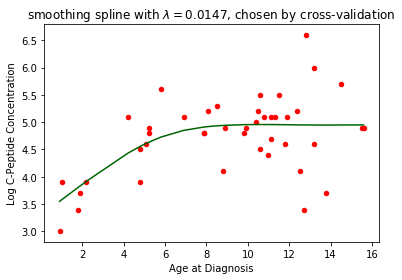

In [21]:
spline_cv = r_smooth_spline(r_age,r_y,cv=True) 
#note the difference from T in Python (because it is an argument to a Python implementation of an R function)
lambda_cv = float(str(spline_cv.rx2("lambda"))[4:-1])
ax19 = diab.plot.scatter(x='age',y='y',c='Red',title="smoothing spline with $\lambda=$"+str(np.round(lambda_cv,4))+", chosen by cross-validation")
_ = ax19.set_xlabel("Age at Diagnosis")
_ = ax19.set_ylabel("Log C-Peptide Concentration")
_ = ax19.add_line(mlines.Line2D(np.array(tuple(spline_cv.rx2("x"))),np.array(tuple(spline_cv.rx2("y"))),color="darkgreen"))

In [ ]:
from statsmodels.stats.anova import anova_lm
print(anova_lm(fit1_lm,fit2_lm,test="F"))

In [23]:
#Statsmodels does not yet support ANOVA on GLMs (https://github.com/statsmodels/statsmodels/issues/825)
r_glm = robjects.r['glm']
r_anova = robjects.r['anova']
r_ybin = robjects.BoolVector(y_bin)
#need to create formula object and populate virtual R environment with objects from Python environment
fit1_glm_fmla = robjects.Formula("r_ybin~r_age")
fit1_glm_fmla.environment['r_ybin']=r_ybin
fit1_glm_fmla.environment['r_age']=r_age
fit1_glm = r_glm(fit1_glm_fmla, family="binomial")
fit2_glm_fmla = robjects.Formula("r_ybin ~ poly(r_age,3,raw=T)") #here, we do use T because it's an R formula
fit2_glm_fmla.environment['r_ybin']=r_ybin
fit2_glm_fmla.environment['r_age']=r_age
fit2_glm = r_glm(fit2_glm_fmla, family="binomial")
print(r_anova(fit1_glm,fit2_glm,test="Chi"))

Analysis of Deviance Table

Model 1: r_ybin ~ r_age
Model 2: r_ybin ~ poly(r_age, 3, raw = T)
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)   
1        41     30.443                        
2        39     16.684  2   13.759 0.001029 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [24]:
def h(x, xi, pow_arg): #pow is a reserved keyword in Python
    if (x > xi):
        return pow((x-xi),pow_arg)
    else:
        return 0
h = np.vectorize(h,otypes=[np.float]) #default behavior is to return ints, which gives incorrect answer
#also, vectorize does not play nicely with default arguments, so better to set directly (e.g., pow_arg=1)

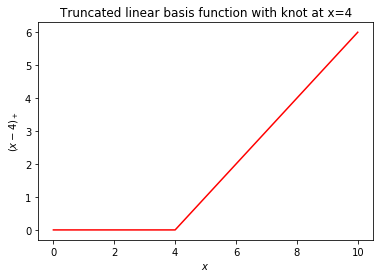

In [25]:
xvals = np.arange(0,10.1,0.1)
ax20 = plt.plot(xvals,h(xvals,4,1),color="red")
_ = plt.title("Truncated linear basis function with knot at x=4")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$(x-4)_+$") #note the use of TeX in the label

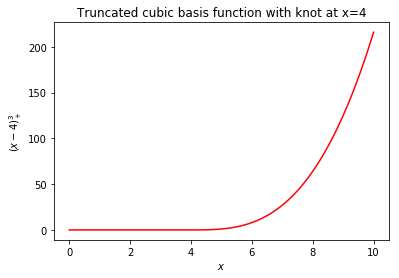

In [26]:
ax21 = plt.plot(xvals,h(xvals,4,3),color="red")
_ = plt.title("Truncated cubic basis function with knot at x=4")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$(x-4)_+^3$")

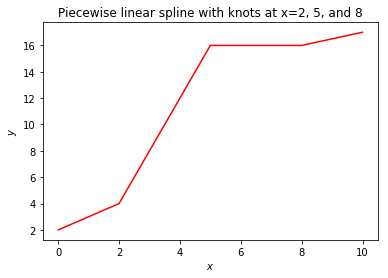

In [27]:
ax22 = plt.plot(xvals,2+xvals+3*h(xvals,2,1)-4*h(xvals,5,1)+0.5*h(xvals,8,1),color="red")
_ = plt.title("Piecewise linear spline with knots at x=2, 5, and 8")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")

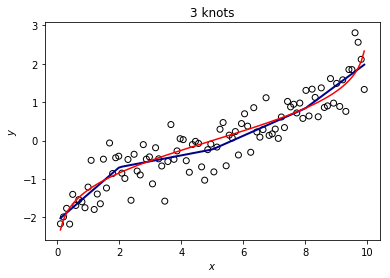

In [28]:
x = np.arange(0.1,10,9.9/100) 
from scipy.stats import norm
#ppf (percent point function) is the rather unusual name for
#the quantile or inverse CDF function in SciPy
y = norm.ppf(x/10) + np.random.normal(0,0.4,100)
ax23 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("3 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols('y~x+h(x,2,1)+h(x,5,1)+h(x,8,1)',data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

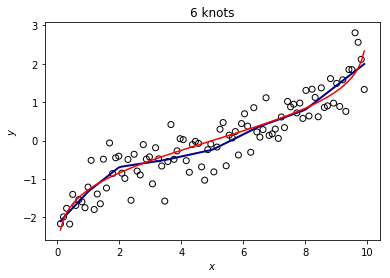

In [29]:
ax24 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("6 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols('y~x+h(x,1,1)+h(x,2,1)+h(x,3.5,1)+h(x,5,1)+h(x,6.5,1)+h(x,8,1)',data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

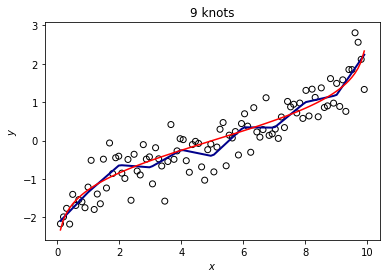

In [30]:
ax25 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("9 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols('y~x+h(x,1,1)+h(x,2,1)+h(x,3,1)+h(x,4,1)+h(x,5,1)+h(x,6,1)+h(x,7,1)+h(x,8,1)+h(x,9,1)',data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

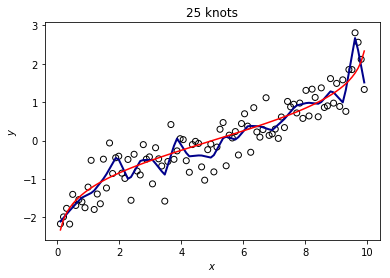

In [31]:
regstr = 'y~x+'
for i in range(1,26):
    regstr += 'h(x,'+str(i/26*10)+',1)+'
regstr = regstr[:-1] #drop last +
ax26 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("25 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols(regstr,data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

In [32]:
#So, we see that increasing the number of knots results in a more polynomial-like fit

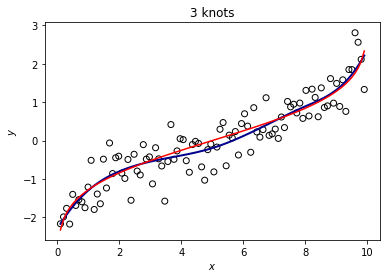

In [33]:
#Next, we look at cubic splines with increasing numbers of knots
ax27 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("3 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols('y~x+np.power(x,2)+np.power(x,3)+h(x,2,3)+h(x,5,3)+h(x,8,3)',data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

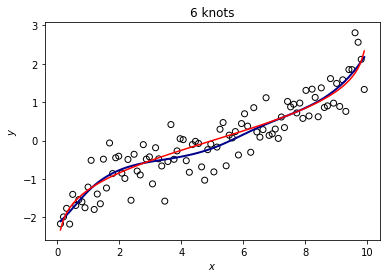

In [34]:
ax28 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("6 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols('y~x+np.power(x,2)+np.power(x,3)+h(x,1,3)+h(x,2,3)+h(x,3.5,3)+h(x,5,3)+h(x,6.5,3)+h(x,8,3)',data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

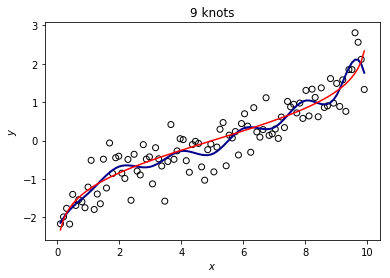

In [35]:
ax29 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("9 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols('y~x+np.power(x,2)+np.power(x,3)+h(x,1,3)+h(x,2,3)+h(x,3,3)+h(x,4,3)+h(x,5,3)+h(x,6,3)+h(x,7,3)+h(x,8,3)+h(x,9,3)',data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

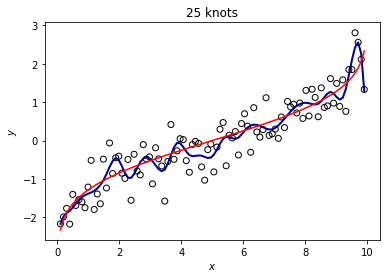

In [36]:
regstr2 = 'y~x+np.power(x,2)+np.power(x,3)+'
for i in range(1,26):
    regstr2 += 'h(x,'+str(i/26*10)+',3)+'
regstr2 = regstr2[:-1] #drop last +
ax30 = plt.scatter(x,y,facecolors='none', edgecolors='black')
_ = plt.title("25 knots")
_ = plt.xlabel("$x$")
_ = plt.ylabel("$y$")
_ = plt.plot(x,sm.ols(regstr2,data={'x':x,'y':y}).fit().predict(),color="darkblue",linewidth=2)
_ = plt.plot(x,norm.ppf(x/10),color="red")

In [37]:
#We will now work with a new dataset, called GAGurine.
#The dataset description (from the R package MASS) is below:
#Data were collected on the concentration of a chemical GAG 
# in the urine of 314 children aged from zero to seventeen years. 
# The aim of the study was to produce a chart to help a paediatrican
# to assess if a child's GAG concentration is ‘normal’.

#The variables are:
# Age: age of child in years.
# GAG: concentration of GAG (the units have been lost).

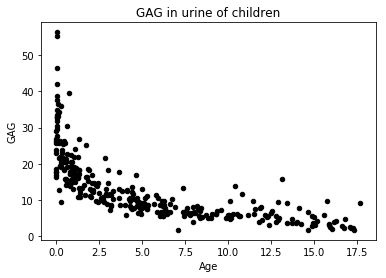

In [38]:
GAGurine = pd.read_csv("GAGurine.csv")
ax31 = GAGurine.plot.scatter(x='Age',y='GAG',c='black',title="GAG in urine of children")
_ = ax31.set_xlabel("Age")
_ = ax31.set_ylabel("GAG")

In [39]:
quarts = GAGurine[['Age']].quantile([0.25, 0.5, 0.75])
quarts = pd.np.array(quarts).flatten() #convert from pandas dataframe to flat NumPy array
#scipy.interpolate has a function called CubicSpline, but this does not allow us to specify knots
# and also requires strictly increasing values in order to fit.
#Therefore, we will call on the R functions ns and bs in the splines package
#to allow us to fit natural splines and B-splines respectively

In [40]:
Age = pd.np.array(GAGurine[['Age']]).flatten()
GAG = pd.np.array(GAGurine[['GAG']]).flatten()
r_Age = robjects.FloatVector(Age)
r_quarts = robjects.FloatVector(quarts)
from rpy2.robjects.packages import importr
r_splines = importr('splines')
Age_ns = np.array(r_splines.ns(r_Age,knots=r_quarts))
Age_bs = np.array(r_splines.bs(r_Age,knots=r_quarts))

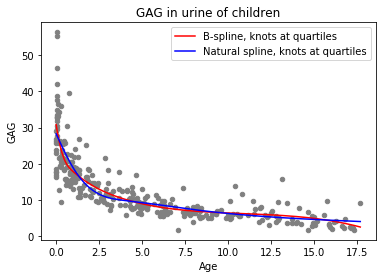

In [41]:
ax32 = GAGurine.plot.scatter(x='Age',y='GAG',c='grey',title="GAG in urine of children")
_ = ax32.set_xlabel("Age")
_ = ax32.set_ylabel("GAG")
_ = ax32.add_line(mlines.Line2D(Age,sm.ols('GAG~Age_bs',data={'GAG':GAG,'Age_bs':Age_bs}).fit().predict(),color='red'))
_ = ax32.add_line(mlines.Line2D(Age,sm.ols('GAG~Age_ns',data={'GAG':GAG,'Age_ns':Age_ns}).fit().predict(),color='blue'))
_ = ax32.legend(["B-spline, knots at quartiles","Natural spline, knots at quartiles"])

In [42]:
kyphosis = pd.read_csv("kyphosis.csv")
kyphosis.describe()

,Age,Number,Start
count,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827
std,58.104251,1.619423,4.883962
min,1.000000,2.000000,1.000000
25%,26.000000,3.000000,9.000000
50%,87.000000,4.000000,13.000000
75%,130.000000,5.000000,16.000000
max,206.000000,10.000000,18.000000


In [43]:
#If there are errors about missing R packages, run the code below:

#r_utils = importr('utils')
#r_utils.install_packages('codetools')
#r_utils.install_packages('gam')

In [44]:
#There is a Python library in development for using GAMs (https://github.com/dswah/pyGAM)
# but it is not yet as comprehensive as the R GAM library, which we will use here instead.
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam
r_kyph = robjects.FactorVector(kyphosis[["Kyphosis"]].values.flatten())
r_Age = robjects.FloatVector(kyphosis[["Age"]].values.flatten())
r_Number = robjects.FloatVector(kyphosis[["Number"]].values.flatten())
r_Start = robjects.FloatVector(kyphosis[["Start"]].values.flatten())
kyph0_fmla = robjects.Formula("Kyphosis~1")
kyph0_fmla.environment['Kyphosis']=r_kyph
kyph1_fmla = robjects.Formula("Kyphosis ~ s(Age) + s(Number) + s(Start)")
kyph1_fmla.environment['Kyphosis']=r_kyph
kyph1_fmla.environment['Age']=r_Age
kyph1_fmla.environment['Number']=r_Number
kyph1_fmla.environment['Start']=r_Start

In [45]:
kyph0_gam = r_gam(kyph0_fmla,family="binomial")
kyph1_gam = r_gam(kyph1_fmla,family="binomial")
print(r_anova(kyph0_gam,kyph1_gam,test="Chi"))

Analysis of Deviance Table

Model 1: Kyphosis ~ 1
Model 2: Kyphosis ~ s(Age) + s(Number) + s(Start)
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)    
1        80     83.234                         
2        68     40.526 12   42.709 2.53e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [46]:
r_residuals = robjects.r['residuals']
dev_resid = np.array(r_residuals(kyph1_gam,type="deviance"))
r_preplot = robjects.r['preplot']
kyph1_gam_preplot = r_preplot(kyph1_gam, resid=True, rug=False)
age_smooth = np.array(kyph1_gam_preplot.rx2('s(Age)').rx2('y'))
number_smooth = np.array(kyph1_gam_preplot.rx2('s(Number)').rx2('y'))
start_smooth = np.array(kyph1_gam_preplot.rx2('s(Start)').rx2('y'))

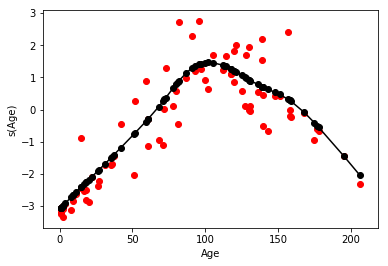

In [47]:
#here we plot each variable vs. its smooth + the deviance residuals
ax33 = plt.axes()
_ = plt.scatter(x=kyphosis[["Age"]].values.flatten(),y=age_smooth+dev_resid,c="red")
_ = plt.scatter(x=kyphosis[["Age"]].values.flatten(),y=age_smooth,c="black")
fit33 = sorted(list(zip(kyphosis[["Age"]].values.flatten(),age_smooth)))
_ = plt.plot([i[0] for i in fit33],[i[1] for i in fit33],c="black")
_ = plt.xlabel("Age")
_ = plt.ylabel("s(Age)")

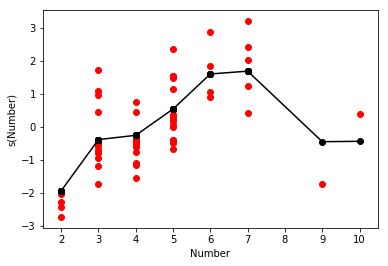

In [48]:
ax34 = plt.axes()
_ = plt.scatter(x=kyphosis[["Number"]].values.flatten(),y=number_smooth+dev_resid,c="red")
_ = plt.scatter(x=kyphosis[["Number"]].values.flatten(),y=number_smooth,c="black")
fit34 = sorted(list(zip(kyphosis[["Number"]].values.flatten(),number_smooth)))
_ = plt.plot([i[0] for i in fit34],[i[1] for i in fit34],c="black")
_ = plt.xlabel("Number")
_ = plt.ylabel("s(Number)")

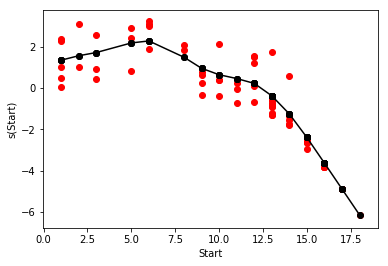

In [49]:
ax35 = plt.axes()
_ = plt.scatter(x=kyphosis[["Start"]].values.flatten(),y=start_smooth+dev_resid,c="red")
_ = plt.scatter(x=kyphosis[["Start"]].values.flatten(),y=start_smooth,c="black")
fit35 = sorted(list(zip(kyphosis[["Start"]].values.flatten(),start_smooth)))
_ = plt.plot([i[0] for i in fit35],[i[1] for i in fit35],c="black")
_ = plt.xlabel("Start")
_ = plt.ylabel("s(Start)")

In [50]:
# remove Number, and refit gam
kyph2_fmla = robjects.Formula("Kyphosis ~ s(Age) + s(Start)")
kyph2_fmla.environment['Kyphosis']=r_kyph
kyph2_fmla.environment['Age']=r_Age
kyph2_fmla.environment['Start']=r_Start
kyph2_gam = r_gam(kyph2_fmla,family="binomial")

In [51]:
kyph2_dev_resid = np.array(r_residuals(kyph2_gam,type="deviance"))
kyph2_gam_preplot = r_preplot(kyph2_gam, resid=True, rug=False)
kyph2_age_smooth = np.array(kyph2_gam_preplot.rx2('s(Age)').rx2('y'))
kyph2_start_smooth = np.array(kyph2_gam_preplot.rx2('s(Start)').rx2('y'))

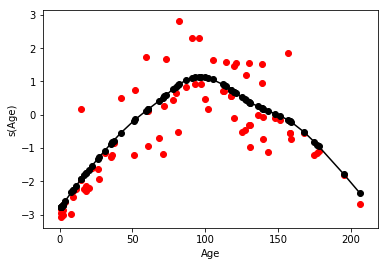

In [52]:
ax36 = plt.axes()
_ = plt.scatter(x=kyphosis[["Age"]].values.flatten(),y=kyph2_age_smooth+kyph2_dev_resid,c="red")
_ = plt.scatter(x=kyphosis[["Age"]].values.flatten(),y=kyph2_age_smooth,c="black")
fit36 = sorted(list(zip(kyphosis[["Age"]].values.flatten(),kyph2_age_smooth)))
_ = plt.plot([i[0] for i in fit36],[i[1] for i in fit36],c="black")
_ = plt.xlabel("Age")
_ = plt.ylabel("s(Age)")

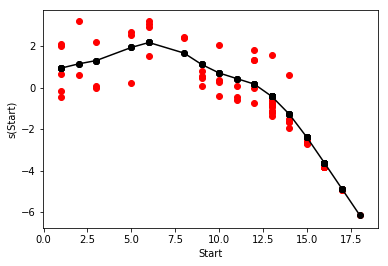

In [53]:
ax37 = plt.axes()
_ = plt.scatter(x=kyphosis[["Start"]].values.flatten(),y=kyph2_start_smooth+kyph2_dev_resid,c="red")
_ = plt.scatter(x=kyphosis[["Start"]].values.flatten(),y=kyph2_start_smooth,c="black")
fit37 = sorted(list(zip(kyphosis[["Start"]].values.flatten(),kyph2_start_smooth)))
_ = plt.plot([i[0] for i in fit37],[i[1] for i in fit37],c="black")
_ = plt.xlabel("Start")
_ = plt.ylabel("s(Start)")

In [54]:
# fit corresponding GLM, and test comparison to GAM
kyph2_glm_fmla = robjects.Formula("Kyphosis ~ Age + Start")
kyph2_glm_fmla.environment['Kyphosis']=r_kyph
kyph2_glm_fmla.environment['Age']=r_Age
kyph2_glm_fmla.environment['Start']=r_Start
kyph2_glm = r_glm(kyph2_fmla,family="binomial")
print(r_anova(kyph2_glm,kyph2_gam,test="Chi"))

Analysis of Deviance Table

Model 1: Kyphosis ~ s(Age) + s(Start)
Model 2: Kyphosis ~ s(Age) + s(Start)
  Resid. Df Resid. Dev     Df Deviance Pr(>Chi)   
1        78     65.299                            
2        72     48.299 6.0002       17 0.009284 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [55]:
r_predict = robjects.r['predict']
kyph_new = robjects.DataFrame({'Age': robjects.IntVector((84,85,86)), 'Start': robjects.IntVector((7,8,9))})
print(r_predict(kyph2_gam,kyph_new,type="response"))

        1         2         3 
0.8528016 0.7985301 0.7017976 



In [56]:
# using GAM to transform predictors

# based on plots for kyph2.gam, seems that including
# quadratic terms of Age and Start make sense to the GLM.
kyphosis["AgeSq"]=(kyphosis[["Age"]]-np.mean(kyphosis[["Age"]]))**2
kyphosis["StartSq"]=(kyphosis[["Start"]]-np.mean(kyphosis[["Start"]]))**2
r_AgeSq = robjects.FloatVector(kyphosis[["AgeSq"]].values.flatten())
r_StartSq = robjects.FloatVector(kyphosis[["StartSq"]].values.flatten())
kyph3_glm_fmla = robjects.Formula("Kyphosis ~ Age + Start + AgeSq + StartSq")
kyph3_glm_fmla.environment['Kyphosis']=r_kyph
kyph3_glm_fmla.environment['Age']=r_Age
kyph3_glm_fmla.environment['Start']=r_Start
kyph3_glm_fmla.environment['Age']=r_Age
kyph3_glm_fmla.environment['StartSq']=r_StartSq
kyph3_glm_fmla.environment['AgeSq']=r_AgeSq
kyph3_glm = r_glm(kyph3_glm_fmla,family="binomial")

In [57]:
print(r_anova(kyph2_glm,kyph3_glm,test="Chi"))

Analysis of Deviance Table

Model 1: Kyphosis ~ s(Age) + s(Start)
Model 2: Kyphosis ~ Age + Start + AgeSq + StartSq
  Resid. Df Resid. Dev Df Deviance  Pr(>Chi)    
1        78     65.299                          
2        76     51.298  2   14.002 0.0009112 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

